# Deep Learning: Endoscopy segmentation.
[Dataset](https://www.kaggle.com/datasets/newslab/cholecseg8k?resource=download)

In [1]:
import os

os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"

In [2]:
import torch
from glob import glob
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import cv2
import random
from Uformer import modelPoolAndAtt
from losses import losses
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [3]:
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'NVIDIA GeForce RTX 2060 SUPER')

In [4]:
SEED = 33
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.use_deterministic_algorithms(True)

In [5]:
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

NUM_CLASSES = 13
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 3e-4
NUM_EPOCHS = 100
BATCH_SIZE = 32
# define the input image dimensions
INPUT_IMAGE_WIDTH = 64
INPUT_IMAGE_HEIGHT = 64

## Data preparation.

In [6]:
IMAGE_DATASET_PATH = glob(f'../../Cholec8k/*/*/*/frame_*_endo.png')
MASK_DATASET_PATH  = glob(f'../../Cholec8k/*/*/*/frame_*_endo_watershed_mask.png')
N = len(IMAGE_DATASET_PATH)
assert len(IMAGE_DATASET_PATH) == len(MASK_DATASET_PATH)

print(f'Number of samples: {str(len(MASK_DATASET_PATH))}')

Number of samples: 8080


In [7]:
# https://gist.github.com/IdeaKing/11cf5e146d23c5bb219ba3508cca89ec
def resize_with_pad(image: np.array, 
                    new_shape, 
                    padding_color = (0, 0, 0)) -> np.array:
    """Maintains aspect ratio and resizes with padding.
    Params:
        image: Image to be resized.
        new_shape: Expected (width, height) of new image.
        padding_color: Tuple in BGR of padding color
    Returns:
        image: Resized image with padding
    """
    original_shape = (image.shape[1], image.shape[0])
    ratio = float(max(new_shape))/max(original_shape)
    new_size = tuple([int(x*ratio) for x in original_shape])
    image = cv2.resize(image, new_size, interpolation=cv2.INTER_NEAREST)
    delta_w = new_shape[0] - new_size[0]
    delta_h = new_shape[1] - new_size[1]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
    return image

In [8]:
def to_categorical(y, num_classes=None, dtype="float32"):
	y = np.array(y, dtype="int")
	input_shape = y.shape

	# Shrink the last dimension if the shape is (..., 1).
	if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
		input_shape = tuple(input_shape[:-1])

	y = y.reshape(-1)
	if not num_classes:
		num_classes = np.max(y) + 1
	n = y.shape[0]
	categorical = np.zeros((n, num_classes), dtype=dtype)
	categorical[np.arange(n), y] = 1
	output_shape = input_shape + (num_classes,)
	categorical = np.reshape(categorical, output_shape)
	return categorical

labels = [[11],[21],[13],[12],[31],[23],[24],[25],[32],[22],[33],[5]]
def encode_mask(masks_arr, n_classes=NUM_CLASSES, H=INPUT_IMAGE_HEIGHT, W=INPUT_IMAGE_WIDTH, labels_arr=labels):
    y_encoded = np.zeros((H, W, 1), dtype=np.uint8)

    for i, label in enumerate(labels_arr):
        y_encoded[np.all(label == masks_arr, axis=-1)] = i + 1
    
    return to_categorical(y_encoded, num_classes=n_classes)

class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths

	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = image[10:-10, 120:-120,:]
		image = resize_with_pad(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image / 255
		image = torch.from_numpy(np.float32(image))
		image = image.permute(2,0,1)

		mask = cv2.imread(self.maskPaths[idx])
		mask = mask[10:-10, 120:-120,:]
		mask = resize_with_pad(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), (50, 50, 50))
		mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
		mask = np.expand_dims(mask, axis=-1)
		mask = encode_mask(mask)
		mask = torch.from_numpy(np.float32(mask))
		mask = mask.permute(2,0,1)

		assert image.shape == (3, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad image shape {image.shape}"
		assert mask.shape == (13, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad mask shape {mask.shape}"

		# return a tuple of the image and its mask
		return image, mask

In [9]:
uformer = modelPoolAndAtt.Uformer(img_size=INPUT_IMAGE_HEIGHT,in_chans=13, embed_dim=16, win_size=8, token_projection='linear', token_mlp='leff',modulator=True)
trainImages, testImages, trainMasks, testMasks = train_test_split(IMAGE_DATASET_PATH, MASK_DATASET_PATH, test_size=0.2, random_state=43)

c:\Users\alexg\miniconda3\envs\pytorch-gpu\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [10]:
# define transformations
from torch.utils.data import DataLoader

# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
num_workers = 4
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

trainLoader = DataLoader(
	trainDS, 
	shuffle=True,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)
testLoader = DataLoader(
	testDS, shuffle=False,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)

[INFO] found 6464 examples in the training set...
[INFO] found 1616 examples in the test set...


In [11]:
uformer = uformer.to(DEVICE)
softmax = torch.nn.Softmax(1)
# initialize loss function and optimizer
lossFunc = losses.TverskyLoss().cuda()
opt = torch.optim.Adam(uformer.parameters(), lr=INIT_LR, betas=(0.9, 0.999),eps=1e-8, weight_decay=1e-5)
iouMetric = losses.MeanIoU().cuda()
gdlMetric = losses.DiceCoeficient().cuda()
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE + 1
testSteps = len(testDS) // BATCH_SIZE + 1
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": [], "train_IoU": [], "test_IoU": [],"train_DC": [], "test_DC": []}

In [12]:
bestIoU = 0
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in range(NUM_EPOCHS):
	#torch.cuda.empty_cache()
	# set the model in training mode
	uformer.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0

	totalTrainIoU = 0
	totalTestIoU = 0
	totalTrainDC = 0
	totalTestDC = 0
	# loop over the training set
	for i, (x, y) in enumerate(tqdm(trainLoader)):
		# send the input to the device
		x, y = x.to(DEVICE), y.to(DEVICE)
		# perform a forward pass and calculate the training loss
		pred = uformer(x)
		assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
		pred = softmax(pred)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
		totalTrainIoU += iouMetric(pred, y)
		totalTrainDC += gdlMetric(pred, y)
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		uformer.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			# make the predictions and calculate the validation loss
			pred = uformer(x)
			assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
			pred = softmax(pred)
			totalTestLoss += lossFunc(pred, y)
			totalTestIoU += iouMetric(pred, y)
			totalTestDC += gdlMetric(pred, y)
			
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps

	avgTrainIoU = totalTrainIoU / trainSteps
	avgTestIoU = totalTestIoU / testSteps
	avgTrainDC = totalTrainDC / trainSteps
	avgTestDC = totalTestDC / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())

	H["train_IoU"].append(avgTrainIoU.cpu().detach().numpy())
	H["test_IoU"].append(avgTestIoU.cpu().detach().numpy())
	H["train_DC"].append(avgTrainDC.cpu().detach().numpy())
	H["test_DC"].append(avgTestDC.cpu().detach().numpy())

	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print(f"Train loss: {avgTrainLoss:.6f}, Test loss: {avgTestLoss:.4f}, " + 
       f"Train IoU: {avgTrainIoU:.4f}, Test IoU: {avgTestIoU:.4f}, Train Dice: {avgTrainDC:.4f}, Test Dice: {avgTestDC:.4f}")
	
	if avgTestIoU > bestIoU:
		bestIoU = avgTestIoU
		torch.save(uformer.state_dict(), '../models/uformerpoolandatt_tversky.pth')
		print('Best IoU improved. Model saved.')
		
# display the total time needed to perform the training 
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))
print(f'Best IoU is: {bestIoU:.5f}')

[INFO] training the network...


100%|██████████| 202/202 [02:25<00:00,  1.39it/s]


[INFO] EPOCH: 1/100
Train loss: 0.377673, Test loss: 0.2338, Train IoU: 0.4679, Test IoU: 0.6222, Train Dice: 0.6174, Test Dice: 0.7662
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:41<00:00,  2.00it/s]


[INFO] EPOCH: 2/100
Train loss: 0.210558, Test loss: 0.1957, Train IoU: 0.6492, Test IoU: 0.6740, Train Dice: 0.7845, Test Dice: 0.8043
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 3/100
Train loss: 0.184784, Test loss: 0.1555, Train IoU: 0.6850, Test IoU: 0.7324, Train Dice: 0.8103, Test Dice: 0.8445
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.03it/s]


[INFO] EPOCH: 4/100
Train loss: 0.135293, Test loss: 0.1268, Train IoU: 0.7586, Test IoU: 0.7765, Train Dice: 0.8598, Test Dice: 0.8732
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 5/100
Train loss: 0.123361, Test loss: 0.1193, Train IoU: 0.7771, Test IoU: 0.7881, Train Dice: 0.8717, Test Dice: 0.8807
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:42<00:00,  1.96it/s]


[INFO] EPOCH: 6/100
Train loss: 0.111854, Test loss: 0.1042, Train IoU: 0.7956, Test IoU: 0.8126, Train Dice: 0.8832, Test Dice: 0.8958
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:44<00:00,  1.93it/s]


[INFO] EPOCH: 7/100
Train loss: 0.102115, Test loss: 0.0980, Train IoU: 0.8113, Test IoU: 0.8229, Train Dice: 0.8930, Test Dice: 0.9020
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 8/100
Train loss: 0.098027, Test loss: 0.0945, Train IoU: 0.8179, Test IoU: 0.8286, Train Dice: 0.8970, Test Dice: 0.9055
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 9/100
Train loss: 0.094372, Test loss: 0.0921, Train IoU: 0.8239, Test IoU: 0.8326, Train Dice: 0.9007, Test Dice: 0.9079
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 10/100
Train loss: 0.092024, Test loss: 0.0926, Train IoU: 0.8277, Test IoU: 0.8316, Train Dice: 0.9031, Test Dice: 0.9074


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 11/100
Train loss: 0.091393, Test loss: 0.0905, Train IoU: 0.8287, Test IoU: 0.8351, Train Dice: 0.9037, Test Dice: 0.9095
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 12/100
Train loss: 0.089983, Test loss: 0.0906, Train IoU: 0.8310, Test IoU: 0.8349, Train Dice: 0.9051, Test Dice: 0.9094


100%|██████████| 202/202 [01:41<00:00,  1.98it/s]


[INFO] EPOCH: 13/100
Train loss: 0.089977, Test loss: 0.0889, Train IoU: 0.8310, Test IoU: 0.8377, Train Dice: 0.9051, Test Dice: 0.9111
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.01it/s]


[INFO] EPOCH: 14/100
Train loss: 0.088877, Test loss: 0.0876, Train IoU: 0.8328, Test IoU: 0.8399, Train Dice: 0.9062, Test Dice: 0.9124
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.00it/s]


[INFO] EPOCH: 15/100
Train loss: 0.087259, Test loss: 0.0865, Train IoU: 0.8355, Test IoU: 0.8418, Train Dice: 0.9078, Test Dice: 0.9135
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 16/100
Train loss: 0.086275, Test loss: 0.0862, Train IoU: 0.8372, Test IoU: 0.8422, Train Dice: 0.9088, Test Dice: 0.9138
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 17/100
Train loss: 0.086098, Test loss: 0.0860, Train IoU: 0.8375, Test IoU: 0.8425, Train Dice: 0.9090, Test Dice: 0.9140
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.01it/s]


[INFO] EPOCH: 18/100
Train loss: 0.085336, Test loss: 0.0863, Train IoU: 0.8387, Test IoU: 0.8421, Train Dice: 0.9097, Test Dice: 0.9137


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 19/100
Train loss: 0.085003, Test loss: 0.0855, Train IoU: 0.8392, Test IoU: 0.8433, Train Dice: 0.9101, Test Dice: 0.9145
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 20/100
Train loss: 0.085037, Test loss: 0.0844, Train IoU: 0.8392, Test IoU: 0.8451, Train Dice: 0.9100, Test Dice: 0.9156
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 21/100
Train loss: 0.085944, Test loss: 0.0807, Train IoU: 0.8377, Test IoU: 0.8516, Train Dice: 0.9091, Test Dice: 0.9193
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.01it/s]


[INFO] EPOCH: 22/100
Train loss: 0.078548, Test loss: 0.0768, Train IoU: 0.8503, Test IoU: 0.8582, Train Dice: 0.9165, Test Dice: 0.9232
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 23/100
Train loss: 0.074074, Test loss: 0.0739, Train IoU: 0.8580, Test IoU: 0.8633, Train Dice: 0.9210, Test Dice: 0.9261
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 24/100
Train loss: 0.071372, Test loss: 0.0711, Train IoU: 0.8628, Test IoU: 0.8682, Train Dice: 0.9237, Test Dice: 0.9289
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 25/100
Train loss: 0.069630, Test loss: 0.0700, Train IoU: 0.8657, Test IoU: 0.8701, Train Dice: 0.9254, Test Dice: 0.9300
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 26/100
Train loss: 0.068175, Test loss: 0.0692, Train IoU: 0.8683, Test IoU: 0.8716, Train Dice: 0.9269, Test Dice: 0.9308
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.01it/s]


[INFO] EPOCH: 27/100
Train loss: 0.066973, Test loss: 0.0685, Train IoU: 0.8704, Test IoU: 0.8729, Train Dice: 0.9281, Test Dice: 0.9315
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.01it/s]


[INFO] EPOCH: 28/100
Train loss: 0.067328, Test loss: 0.0680, Train IoU: 0.8697, Test IoU: 0.8735, Train Dice: 0.9277, Test Dice: 0.9320
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.00it/s]


[INFO] EPOCH: 29/100
Train loss: 0.067017, Test loss: 0.0698, Train IoU: 0.8703, Test IoU: 0.8702, Train Dice: 0.9281, Test Dice: 0.9302


100%|██████████| 202/202 [01:41<00:00,  1.99it/s]


[INFO] EPOCH: 30/100
Train loss: 0.066604, Test loss: 0.0675, Train IoU: 0.8710, Test IoU: 0.8744, Train Dice: 0.9285, Test Dice: 0.9325
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 31/100
Train loss: 0.064448, Test loss: 0.0662, Train IoU: 0.8748, Test IoU: 0.8766, Train Dice: 0.9306, Test Dice: 0.9338
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:41<00:00,  1.99it/s]


[INFO] EPOCH: 32/100
Train loss: 0.055173, Test loss: 0.0482, Train IoU: 0.8913, Test IoU: 0.9086, Train Dice: 0.9399, Test Dice: 0.9518
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 33/100
Train loss: 0.047297, Test loss: 0.0470, Train IoU: 0.9054, Test IoU: 0.9110, Train Dice: 0.9478, Test Dice: 0.9530
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 34/100
Train loss: 0.046102, Test loss: 0.0461, Train IoU: 0.9075, Test IoU: 0.9125, Train Dice: 0.9490, Test Dice: 0.9539
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 35/100
Train loss: 0.045226, Test loss: 0.0456, Train IoU: 0.9091, Test IoU: 0.9133, Train Dice: 0.9498, Test Dice: 0.9544
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:42<00:00,  1.96it/s]


[INFO] EPOCH: 36/100
Train loss: 0.044512, Test loss: 0.0451, Train IoU: 0.9104, Test IoU: 0.9143, Train Dice: 0.9506, Test Dice: 0.9549
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:41<00:00,  2.00it/s]


[INFO] EPOCH: 37/100
Train loss: 0.044080, Test loss: 0.0447, Train IoU: 0.9112, Test IoU: 0.9150, Train Dice: 0.9510, Test Dice: 0.9553
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 38/100
Train loss: 0.043609, Test loss: 0.0442, Train IoU: 0.9121, Test IoU: 0.9159, Train Dice: 0.9515, Test Dice: 0.9558
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 39/100
Train loss: 0.043146, Test loss: 0.0438, Train IoU: 0.9129, Test IoU: 0.9167, Train Dice: 0.9519, Test Dice: 0.9562
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 40/100
Train loss: 0.042945, Test loss: 0.0435, Train IoU: 0.9133, Test IoU: 0.9172, Train Dice: 0.9521, Test Dice: 0.9565
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 41/100
Train loss: 0.043430, Test loss: 0.0435, Train IoU: 0.9124, Test IoU: 0.9171, Train Dice: 0.9516, Test Dice: 0.9565


100%|██████████| 202/202 [01:41<00:00,  1.99it/s]


[INFO] EPOCH: 42/100
Train loss: 0.042299, Test loss: 0.0434, Train IoU: 0.9144, Test IoU: 0.9173, Train Dice: 0.9528, Test Dice: 0.9566
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:41<00:00,  1.98it/s]


[INFO] EPOCH: 43/100
Train loss: 0.041757, Test loss: 0.0426, Train IoU: 0.9154, Test IoU: 0.9187, Train Dice: 0.9533, Test Dice: 0.9574
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.01it/s]


[INFO] EPOCH: 44/100
Train loss: 0.041973, Test loss: 0.0429, Train IoU: 0.9150, Test IoU: 0.9182, Train Dice: 0.9531, Test Dice: 0.9571


100%|██████████| 202/202 [01:40<00:00,  2.00it/s]


[INFO] EPOCH: 45/100
Train loss: 0.041950, Test loss: 0.0431, Train IoU: 0.9151, Test IoU: 0.9178, Train Dice: 0.9531, Test Dice: 0.9569


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 46/100
Train loss: 0.041743, Test loss: 0.0427, Train IoU: 0.9154, Test IoU: 0.9186, Train Dice: 0.9533, Test Dice: 0.9573


100%|██████████| 202/202 [01:40<00:00,  2.01it/s]


[INFO] EPOCH: 47/100
Train loss: 0.041680, Test loss: 0.0432, Train IoU: 0.9155, Test IoU: 0.9177, Train Dice: 0.9534, Test Dice: 0.9568


100%|██████████| 202/202 [01:40<00:00,  2.01it/s]


[INFO] EPOCH: 48/100
Train loss: 0.041082, Test loss: 0.0426, Train IoU: 0.9166, Test IoU: 0.9187, Train Dice: 0.9540, Test Dice: 0.9574
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.01it/s]


[INFO] EPOCH: 49/100
Train loss: 0.040998, Test loss: 0.0421, Train IoU: 0.9168, Test IoU: 0.9197, Train Dice: 0.9541, Test Dice: 0.9579
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.01it/s]


[INFO] EPOCH: 50/100
Train loss: 0.040862, Test loss: 0.0425, Train IoU: 0.9170, Test IoU: 0.9190, Train Dice: 0.9542, Test Dice: 0.9575


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 51/100
Train loss: 0.040485, Test loss: 0.0419, Train IoU: 0.9177, Test IoU: 0.9200, Train Dice: 0.9546, Test Dice: 0.9581
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.01it/s]


[INFO] EPOCH: 52/100
Train loss: 0.040223, Test loss: 0.0422, Train IoU: 0.9182, Test IoU: 0.9195, Train Dice: 0.9549, Test Dice: 0.9578


100%|██████████| 202/202 [01:40<00:00,  2.01it/s]


[INFO] EPOCH: 53/100
Train loss: 0.040599, Test loss: 0.0421, Train IoU: 0.9175, Test IoU: 0.9196, Train Dice: 0.9545, Test Dice: 0.9579


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 54/100
Train loss: 0.040564, Test loss: 0.0414, Train IoU: 0.9176, Test IoU: 0.9209, Train Dice: 0.9545, Test Dice: 0.9586
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.01it/s]


[INFO] EPOCH: 55/100
Train loss: 0.039730, Test loss: 0.0416, Train IoU: 0.9191, Test IoU: 0.9205, Train Dice: 0.9553, Test Dice: 0.9584


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 56/100
Train loss: 0.039996, Test loss: 0.0414, Train IoU: 0.9186, Test IoU: 0.9208, Train Dice: 0.9551, Test Dice: 0.9585


100%|██████████| 202/202 [01:42<00:00,  1.98it/s]


[INFO] EPOCH: 57/100
Train loss: 0.039566, Test loss: 0.0416, Train IoU: 0.9194, Test IoU: 0.9205, Train Dice: 0.9555, Test Dice: 0.9584


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 58/100
Train loss: 0.039697, Test loss: 0.0411, Train IoU: 0.9192, Test IoU: 0.9215, Train Dice: 0.9554, Test Dice: 0.9589
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:42<00:00,  1.96it/s]


[INFO] EPOCH: 59/100
Train loss: 0.040000, Test loss: 0.0416, Train IoU: 0.9186, Test IoU: 0.9206, Train Dice: 0.9551, Test Dice: 0.9584


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 60/100
Train loss: 0.039458, Test loss: 0.0410, Train IoU: 0.9196, Test IoU: 0.9216, Train Dice: 0.9556, Test Dice: 0.9590
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 61/100
Train loss: 0.039387, Test loss: 0.0410, Train IoU: 0.9197, Test IoU: 0.9217, Train Dice: 0.9557, Test Dice: 0.9590
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 62/100
Train loss: 0.040063, Test loss: 0.0412, Train IoU: 0.9185, Test IoU: 0.9213, Train Dice: 0.9550, Test Dice: 0.9588


100%|██████████| 202/202 [01:39<00:00,  2.03it/s]


[INFO] EPOCH: 63/100
Train loss: 0.039093, Test loss: 0.0406, Train IoU: 0.9202, Test IoU: 0.9224, Train Dice: 0.9560, Test Dice: 0.9594
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 64/100
Train loss: 0.038560, Test loss: 0.0408, Train IoU: 0.9212, Test IoU: 0.9220, Train Dice: 0.9565, Test Dice: 0.9592


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 65/100
Train loss: 0.038610, Test loss: 0.0407, Train IoU: 0.9212, Test IoU: 0.9222, Train Dice: 0.9565, Test Dice: 0.9593


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 66/100
Train loss: 0.038470, Test loss: 0.0405, Train IoU: 0.9214, Test IoU: 0.9226, Train Dice: 0.9566, Test Dice: 0.9595
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 67/100
Train loss: 0.038397, Test loss: 0.0406, Train IoU: 0.9216, Test IoU: 0.9223, Train Dice: 0.9567, Test Dice: 0.9594


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 68/100
Train loss: 0.038257, Test loss: 0.0404, Train IoU: 0.9218, Test IoU: 0.9227, Train Dice: 0.9568, Test Dice: 0.9596
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 69/100
Train loss: 0.038565, Test loss: 0.0404, Train IoU: 0.9212, Test IoU: 0.9228, Train Dice: 0.9565, Test Dice: 0.9596
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 70/100
Train loss: 0.038166, Test loss: 0.0404, Train IoU: 0.9220, Test IoU: 0.9228, Train Dice: 0.9569, Test Dice: 0.9596


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 71/100
Train loss: 0.038647, Test loss: 0.0409, Train IoU: 0.9211, Test IoU: 0.9217, Train Dice: 0.9564, Test Dice: 0.9591


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 72/100
Train loss: 0.038848, Test loss: 0.0431, Train IoU: 0.9207, Test IoU: 0.9179, Train Dice: 0.9562, Test Dice: 0.9569


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 73/100
Train loss: 0.039049, Test loss: 0.0408, Train IoU: 0.9203, Test IoU: 0.9220, Train Dice: 0.9560, Test Dice: 0.9592


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 74/100
Train loss: 0.038377, Test loss: 0.0402, Train IoU: 0.9216, Test IoU: 0.9230, Train Dice: 0.9567, Test Dice: 0.9598
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 75/100
Train loss: 0.037882, Test loss: 0.0399, Train IoU: 0.9225, Test IoU: 0.9236, Train Dice: 0.9572, Test Dice: 0.9601
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 76/100
Train loss: 0.037632, Test loss: 0.0403, Train IoU: 0.9229, Test IoU: 0.9229, Train Dice: 0.9574, Test Dice: 0.9597


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 77/100
Train loss: 0.038105, Test loss: 0.0404, Train IoU: 0.9221, Test IoU: 0.9226, Train Dice: 0.9570, Test Dice: 0.9596


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 78/100
Train loss: 0.037779, Test loss: 0.0399, Train IoU: 0.9227, Test IoU: 0.9235, Train Dice: 0.9573, Test Dice: 0.9601


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 79/100
Train loss: 0.037867, Test loss: 0.0401, Train IoU: 0.9225, Test IoU: 0.9233, Train Dice: 0.9572, Test Dice: 0.9599


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 80/100
Train loss: 0.037637, Test loss: 0.0402, Train IoU: 0.9229, Test IoU: 0.9231, Train Dice: 0.9574, Test Dice: 0.9598


100%|██████████| 202/202 [01:42<00:00,  1.98it/s]


[INFO] EPOCH: 81/100
Train loss: 0.037626, Test loss: 0.0400, Train IoU: 0.9229, Test IoU: 0.9235, Train Dice: 0.9574, Test Dice: 0.9600


100%|██████████| 202/202 [01:40<00:00,  2.01it/s]


[INFO] EPOCH: 82/100
Train loss: 0.037513, Test loss: 0.0404, Train IoU: 0.9232, Test IoU: 0.9227, Train Dice: 0.9576, Test Dice: 0.9596


100%|██████████| 202/202 [01:40<00:00,  2.01it/s]


[INFO] EPOCH: 83/100
Train loss: 0.037636, Test loss: 0.0403, Train IoU: 0.9230, Test IoU: 0.9228, Train Dice: 0.9574, Test Dice: 0.9597


100%|██████████| 202/202 [01:40<00:00,  2.01it/s]


[INFO] EPOCH: 84/100
Train loss: 0.037298, Test loss: 0.0398, Train IoU: 0.9236, Test IoU: 0.9239, Train Dice: 0.9578, Test Dice: 0.9602
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:42<00:00,  1.98it/s]


[INFO] EPOCH: 85/100
Train loss: 0.037514, Test loss: 0.0401, Train IoU: 0.9232, Test IoU: 0.9233, Train Dice: 0.9576, Test Dice: 0.9599


100%|██████████| 202/202 [01:41<00:00,  1.99it/s]


[INFO] EPOCH: 86/100
Train loss: 0.037462, Test loss: 0.0401, Train IoU: 0.9232, Test IoU: 0.9233, Train Dice: 0.9576, Test Dice: 0.9599


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 87/100
Train loss: 0.036957, Test loss: 0.0395, Train IoU: 0.9242, Test IoU: 0.9244, Train Dice: 0.9581, Test Dice: 0.9605
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 88/100
Train loss: 0.037212, Test loss: 0.0401, Train IoU: 0.9237, Test IoU: 0.9233, Train Dice: 0.9579, Test Dice: 0.9599


100%|██████████| 202/202 [01:42<00:00,  1.98it/s]


[INFO] EPOCH: 89/100
Train loss: 0.037330, Test loss: 0.0394, Train IoU: 0.9235, Test IoU: 0.9245, Train Dice: 0.9577, Test Dice: 0.9606
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:42<00:00,  1.96it/s]


[INFO] EPOCH: 90/100
Train loss: 0.036956, Test loss: 0.0399, Train IoU: 0.9242, Test IoU: 0.9236, Train Dice: 0.9581, Test Dice: 0.9601


100%|██████████| 202/202 [01:40<00:00,  2.01it/s]


[INFO] EPOCH: 91/100
Train loss: 0.037113, Test loss: 0.0398, Train IoU: 0.9239, Test IoU: 0.9238, Train Dice: 0.9580, Test Dice: 0.9602


100%|██████████| 202/202 [01:40<00:00,  2.01it/s]


[INFO] EPOCH: 92/100
Train loss: 0.036867, Test loss: 0.0398, Train IoU: 0.9244, Test IoU: 0.9238, Train Dice: 0.9582, Test Dice: 0.9602


100%|██████████| 202/202 [01:40<00:00,  2.01it/s]


[INFO] EPOCH: 93/100
Train loss: 0.037028, Test loss: 0.0399, Train IoU: 0.9240, Test IoU: 0.9236, Train Dice: 0.9580, Test Dice: 0.9601


100%|██████████| 202/202 [01:40<00:00,  2.01it/s]


[INFO] EPOCH: 94/100
Train loss: 0.036781, Test loss: 0.0395, Train IoU: 0.9245, Test IoU: 0.9243, Train Dice: 0.9583, Test Dice: 0.9605


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 95/100
Train loss: 0.036832, Test loss: 0.0397, Train IoU: 0.9245, Test IoU: 0.9240, Train Dice: 0.9582, Test Dice: 0.9603


100%|██████████| 202/202 [01:40<00:00,  2.01it/s]


[INFO] EPOCH: 96/100
Train loss: 0.036786, Test loss: 0.0395, Train IoU: 0.9245, Test IoU: 0.9243, Train Dice: 0.9583, Test Dice: 0.9605


100%|██████████| 202/202 [01:40<00:00,  2.01it/s]


[INFO] EPOCH: 97/100
Train loss: 0.036591, Test loss: 0.0401, Train IoU: 0.9249, Test IoU: 0.9234, Train Dice: 0.9585, Test Dice: 0.9599


100%|██████████| 202/202 [01:40<00:00,  2.01it/s]


[INFO] EPOCH: 98/100
Train loss: 0.036566, Test loss: 0.0399, Train IoU: 0.9249, Test IoU: 0.9236, Train Dice: 0.9585, Test Dice: 0.9601


100%|██████████| 202/202 [01:40<00:00,  2.01it/s]


[INFO] EPOCH: 99/100
Train loss: 0.036490, Test loss: 0.0396, Train IoU: 0.9250, Test IoU: 0.9241, Train Dice: 0.9586, Test Dice: 0.9604


100%|██████████| 202/202 [01:40<00:00,  2.01it/s]


[INFO] EPOCH: 100/100
Train loss: 0.036710, Test loss: 0.0397, Train IoU: 0.9246, Test IoU: 0.9241, Train Dice: 0.9584, Test Dice: 0.9603
[INFO] total time taken to train the model: 12267.35s
Best IoU is: 0.92453


In [13]:
# serialize the model to disk
# torch.save(uformer.state_dict(), '../models/uformerpool_tversky.pth')
# uformer.load_state_dict(torch.load('../models/uformer.pth'))

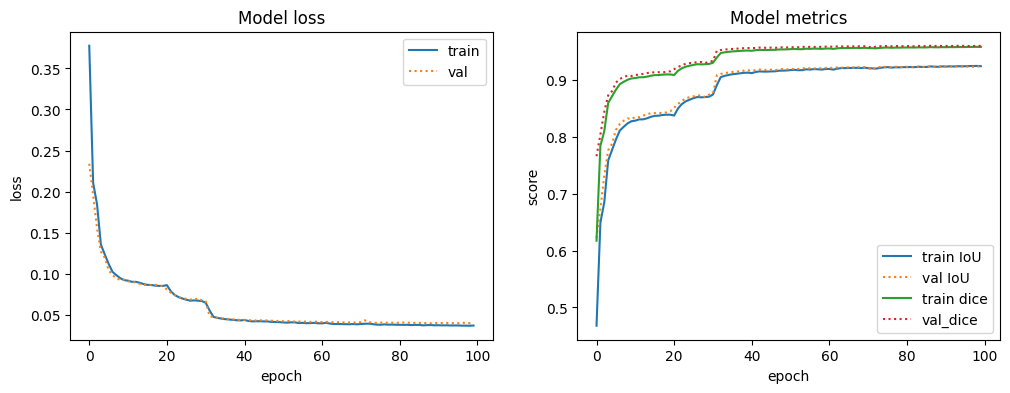

In [14]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(H['train_loss'])
plt.plot(H['test_loss'], linestyle='dotted')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(122)
plt.plot(H['train_IoU'])
plt.plot(H['test_IoU'], linestyle='dotted')
plt.plot(H['train_DC'])
plt.plot(H['test_DC'], linestyle='dotted')
plt.title('Model metrics')
plt.ylabel('score')
plt.xlabel('epoch')

plt.legend(['train IoU', 'val IoU', 'train dice', 'val_dice'], loc='lower right')

plt.show()

In [15]:
def make_prediction(model, image):
	image = torch.Tensor(image).permute((2, 0, 1)).to(DEVICE)
	image = torch.unsqueeze(image, 0)
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		predMask = model(image)
		predMask = softmax(predMask)
		predMask = torch.squeeze(predMask, 0)
		predMask = predMask.permute((1, 2, 0))
		predMask = predMask.cpu().detach().numpy()
		predMask = np.argmax(predMask, axis=-1)
		predMask = np.expand_dims(predMask, axis=-1)
		# filter out the weak predictions and convert them to integers
		return predMask.astype(np.uint8)


In [16]:
def getPredImg(image_path):     
    image = cv2.imread(image_path)
    image = image[10:-10, 120:-120,:]
    image = resize_with_pad(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255
    return image

def getPredMask(mask_path):
    mask = cv2.imread(mask_path)
    mask = mask[10:-10, 120:-120,:]
    mask = resize_with_pad(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), (50, 50, 50))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = np.expand_dims(mask, axis=-1)
    mask = encode_mask(mask)
    return mask

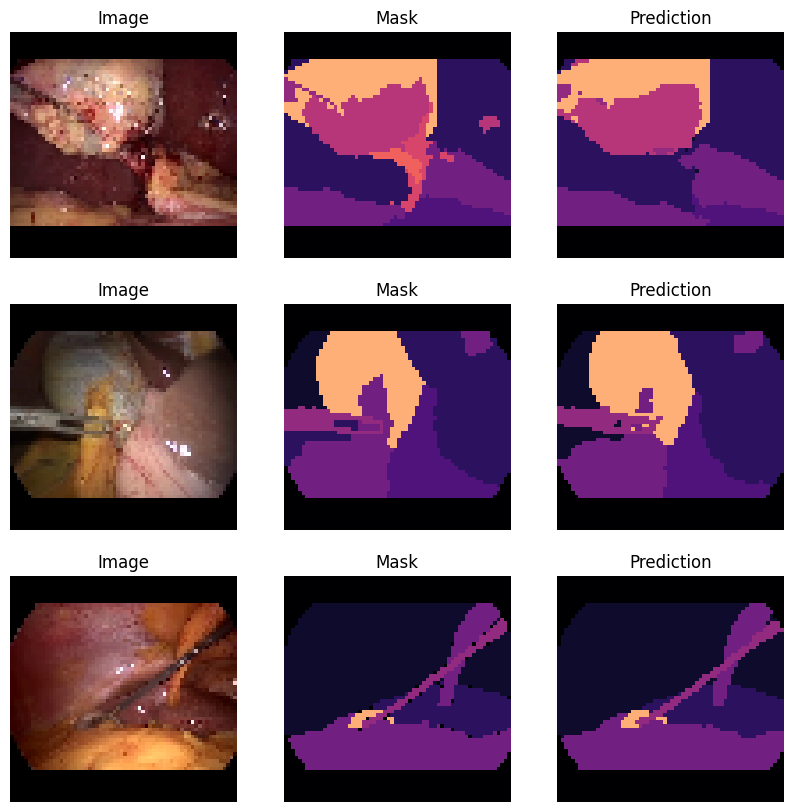

In [17]:
plt.figure(figsize=(10,10))
for i in range(3):    

    idx = random.randint(0, len(testImages) -1)
    img = getPredImg(testImages[idx])
    mask = getPredMask(testMasks[idx])
    
    plt.subplot(331 + 3*i)
    plt.imshow(img)
    plt.title('Image')
    plt.axis("off")

    mask = np.argmax(mask, axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    plt.subplot(332 + 3*i)
    plt.imshow(mask, cmap='magma', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Mask')
    plt.axis("off")

    pred = make_prediction(uformer, img)
    plt.subplot(333 + 3*i)
    plt.imshow(pred, cmap='magma', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Prediction')
    plt.axis("off")

plt.show()

 --- 
 TFG - Alejandro García Mota